In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboard.plugins import projector
import sklearn as sk
import pandas as pd
import numpy as np
import nltk.corpus
import nltk
import os
import datetime
import io
%matplotlib inline
%load_ext tensorboard

lower = False
feature = 'title'
#feature = 'tags'
#feature = 'description'
region, language = 'US', 'english'   # 
#region, language = 'KR', 'korean'    # doesn't work
#region, language = 'MX', 'spanish'   # doesn't work
#region, language = 'CA', 'english'   #
#region, language = 'DE', 'german'    #
#region, language = 'FR', 'french'    #

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

def load_region_data(region: str) -> pd.DataFrame:
    df = pd.read_csv('./archive/{}videos.csv'.format(region))

    # Drop unused columns
    df = df.drop(['thumbnail_link', 'video_id'], axis=1)
    df = df.dropna()

    # Enrich data
    df['publish_hour'] = pd.to_datetime(df['publish_time']).dt.hour
    df['comments_disabled'] = df['comments_disabled'].apply(lambda row: 0 if row == False else 1)
    df['ratings_disabled'] = df['ratings_disabled'].apply(lambda row: 0 if row == False else 1)
    df['video_error_or_removed'] = df['video_error_or_removed'].apply(lambda row: 0 if row == False else 1)
    df['like_dislike'] = df[['likes', 'dislikes']].apply(lambda row: row['likes'] / np.sum([row['likes'], row['dislikes']]), axis=1)
    df['tags'] = df['tags'].apply(lambda row: ' '.join( i.strip('""') for i in row.split('|') ))
    df['anti_participation'] = df[['comments_disabled', 'ratings_disabled']].apply(lambda row: row.sum(), axis=1)

    # Transform category_id to label
    category_le = sk.preprocessing.LabelEncoder()
    category_le.fit(df['category_id'])
    df['category_id'] = category_le.transform(df['category_id'])

    # Load stopwords
    try:
        stop_words = set(nltk.corpus.stopwords.words(language))
    except Exception:
        nltk.download('stopwords')
        stop_words = set(nltk.corpus.stopwords.words(language))
    
    # Drop stopwords
    df['tags'] = df['tags'].apply(lambda row: ' '.join(word for word in row.split() if word not in stop_words))
    df['description'] = df['description'].apply(lambda row: ' '.join(word for word in row.split() if word not in stop_words))
    
    return df, len(category_le.classes_)

df, num_classes = load_region_data(region)
df.head()

Num GPUs Available:  1


<ipython-input-1-2d42a05ed3f3>:40: RuntimeWarning: invalid value encountered in long_scalars
  df['like_dislike'] = df[['likes', 'dislikes']].apply(lambda row: row['likes'] / np.sum([row['likes'], row['dislikes']]), axis=1)


,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,publish_hour,like_dislike,anti_participation
0,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,7,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,0,0,0,SHANTELL'S CHANNEL - https://www.youtube.com/s...,17,0.950970,0
1,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,9,2017-11-13T07:30:00.000Z,last week tonight trump presidency last week t...,2418783,97185,6146,12703,0,0,0,"One year presidential election, John Oliver di...",7,0.940521,0
2,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,8,2017-11-12T19:05:24.000Z,racist superman rudy mancuso king bach racist ...,3191434,146033,5339,8181,0,0,0,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,19,0.964729,0
3,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,9,2017-11-13T11:00:04.000Z,rhett link gmm good mythical morning rhett lin...,343168,10172,666,2146,0,0,0,Today find Link Nickelback amateur secret Nick...,11,0.938550,0
4,17.14.11,I Dare You: GOING BALD!?,nigahiga,9,2017-11-12T18:01:41.000Z,ryan higa higatv nigahiga dare idy rhpc dares ...,2095731,132235,1989,17518,0,0,0,"I know since show, we're back might best episo...",18,0.985181,0


In [2]:
def convert_to_sequences(x):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=lower)
    tokenizer.fit_on_texts(x)
    _sequences = tokenizer.texts_to_sequences(x)
    maxlen = max(len(_seq) for _seq in _sequences)
    vocab_size = len(tokenizer.word_index) + 1
    _xtr = tf.keras.preprocessing.sequence.pad_sequences(_sequences, maxlen, padding='post')
    
    return np.array(_xtr), maxlen, vocab_size

if feature == 'tags':
    _x = df['tags']
elif feature == 'description':
    _x = df['description']
elif feature == 'title': 
    _x = df['title']
    
#X, maxlen, vocab_size = convert_to_sequences(_x.to_numpy())
X = _x.to_numpy()

Y = df['category_id'].to_numpy().reshape((-1,1))

X.shape, Y.shape

((40379,), (40379, 1))

In [3]:
activation = 'softmax'
model = tf.keras.Sequential()

vocab_size = 10000
sequence_length = 25

vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length,
    name='text_vectorize',
)

vectorize_layer.adapt(X)

model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(vocab_size, 75,  name="embedding"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=8, activation=activation))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=6, activation=activation))
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=4, activation=activation))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(num_classes, activation='relu'))

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['categorical_accuracy'],
)

#model.summary()

In [4]:
# Initialize history variables
loss_history, accuracy_history = [[],[]], [[],[]]
final_accuracy = -1.

to_categorical = tf.keras.utils.to_categorical

# tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    embeddings_freq=1,
)
!rm -rf logs/

# Kfold cross validation
skf = sk.model_selection.StratifiedKFold(n_splits=10, shuffle=True)
for train_index, val_index in skf.split(X, Y):
    # Get train and test fold
    xtrain, xval = X[train_index], X[val_index]
    
    # We need to convert the Y to a categorical type in order for the 
    # multi-classifier to train and validate properly
    ytrain = to_categorical(Y[train_index], num_classes=num_classes)
    yval = to_categorical(Y[val_index], num_classes=num_classes)
    
    # Train and validate
    history = model.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=3, batch_size=128, callbacks=[tensorboard_callback])
    
    # Add values to training history
    loss_history[0].extend(history.history['val_loss'])
    loss_history[1].extend(history.history['loss'])
    accuracy_history[0].extend(history.history['val_categorical_accuracy'])
    accuracy_history[1].extend(history.history['categorical_accuracy'])
    final_accuracy = history.history['val_categorical_accuracy'][0]
    
model.summary()

Epoch 1/3
  1/284 [..............................] - ETA: 0s - loss: 9.2586 - categorical_accuracy: 0.0391WARNING:tensorflow:From /home/jc/nyu/ml/proj/venv/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
284/284 [==============================] - 2s 8ms/step - loss: 3.6781 - categorical_accuracy: 0.1160 - val_loss: 2.5962 - val_categorical_accuracy: 0.2429
Epoch 2/3
284/284 [==============================] - 2s 7ms/step - loss: 2.7668 - categorical_accuracy: 0.1609 - val_loss: 2.6453 - val_categorical_accuracy: 0.2429
Epoch 3/3
284/284 [==============================] - 2s 7ms/step - loss: 2.6593 - categorical_accuracy: 0.2126 - val_loss: 2.5212 - val_categorical_accuracy: 0.2429
Epoch 1/3
284/284 [==============================] - 2s 8ms/step - loss: 2.5856 - categorical_accuracy: 0.2349 - val

In [5]:
weights = model.get_layer('embedding').get_weights()[0]
checkpoint = tf.train.Checkpoint(embedding=tf.Variable(weights[1:]))
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

vocab = vectorize_layer.get_vocabulary()

out_v = io.open(os.path.join(log_dir, 'vectors.tsv'), 'w', encoding='utf-8')
out_m = io.open(os.path.join(log_dir, 'metadata.tsv'), 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if  index == 0: continue # skip 0, it's padding.
    vec = weights[index] 
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [6]:
len(weights), len(vocab)

(20000, 11006)

In [7]:
vocab[-1]

'0'

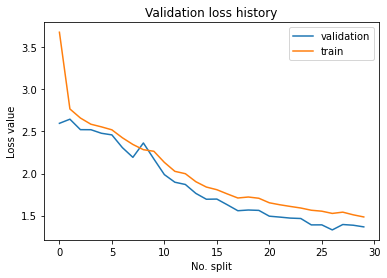

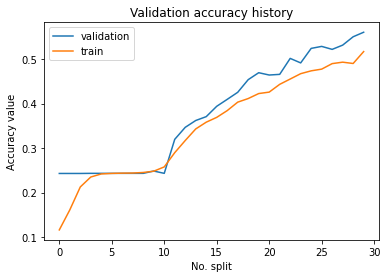

In [8]:
# Visualize history
# Plot history: Loss
fig, ax = plt.subplots()
ax.plot(loss_history[0], label='validation')
ax.plot(loss_history[1], label='train')
ax.set(title='Validation loss history', xlabel='No. split', ylabel='Loss value')
ax.legend()


# Plot history: Accuracy
fig, ax = plt.subplots()
ax.plot(accuracy_history[0], label='validation')
ax.plot(accuracy_history[1], label='train')
ax.set(title='Validation accuracy history', xlabel='No. split', ylabel='Accuracy value')
ax.legend()

plt.show()